# Notebook for DeBERTa-v3-base

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [2]:
from conllu import TokenList
from mlflow.models.model import ModelInfo
import polars as pl
from stanza.models.common.doc import Token
from label_legends.preprocess import create_conllu, holdout, load_conllu, load_data, load_train, load_test, transform, load_vectorizer, reverse_vocabulary, vocabulary, ids_to_tokens, tokens_to_ids, vectorize_tokens, strip_stopwords
import logging
import mlflow
from mlflow import MlflowClient
from label_legends.result import calculate_scores, download_predictions, get_experiment, load_predictions, client, get_current
import json
import torch
from torch.utils.data import Dataset
import time
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoConfig, DebertaV2Tokenizer, EvalPrediction, Trainer, TrainingArguments

from label_legends.util import RESOURCE


logging.basicConfig(level=logging.INFO)

/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training the model

In [3]:
MODEL_NAME = 'microsoft/deberta-v3-base'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer =DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

/home/lukas/.local/share/uv/python/cpython-3.12.5-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  self.pid = os.fork()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/home/lukas/.local/share/uv/python/cpython-3.12.5-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  self.pid = os.fork()


In [4]:
load_data().collect()

id,rewire_id,text,annotator,label_sexist,label_category,label_vector,split,tokens
i64,str,str,i64,str,str,str,str,list[str]
0,"""sexism2022_english-0""",""" I wonder what keeps that witc…",17,"""sexist""","""2. derogation""","""2.2 aggressive and emotive att…","""train""","[""i"", ""wonder"", … ""😄""]"
1,"""sexism2022_english-0""",""" I wonder what keeps that witc…",2,"""sexist""","""2. derogation""","""2.2 aggressive and emotive att…","""train""","[""i"", ""wonder"", … ""😄""]"
10,"""sexism2022_english-100""","""Good for her! My grandson had …",3,"""not sexist""","""none""","""none""","""train""","[""good"", ""for"", … ""!""]"
100,"""sexism2022_english-10026""","""It is not insulting, it's **ex…",14,"""sexist""","""2. derogation""","""2.1 descriptive attacks""","""test""","[""it"", ""be"", … "".**""]"
1000,"""sexism2022_english-10297""","""The article said Madonna offer…",5,"""sexist""","""2. derogation""","""2.3 dehumanising attacks & ove…","""train""","[""the"", ""article"", … "".""]"
…,…,…,…,…,…,…,…,…
9995,"""sexism2022_english-12996""","""Shudder.. if you had to have s…",17,"""sexist""","""2. derogation""","""2.3 dehumanising attacks & ove…","""test""","[""shudder"", "".."", … "".""]"
9996,"""sexism2022_english-12997""","""You mean one that forces women…",6,"""not sexist""","""none""","""none""","""train""","[""you"", ""mean"", … ""?""]"
9997,"""sexism2022_english-12997""","""You mean one that forces women…",4,"""not sexist""","""none""","""none""","""train""","[""you"", ""mean"", … ""?""]"


### Splitting the dataset to training validation test

In [5]:
val, tra = holdout()
tra = transform(tra)
val = transform(val)

train_texts = tra["text"].to_list()
train_labels = tra["label"].to_list()
val_texts = val["text"].to_list()
val_labels = val["label"].to_list()

test = transform(load_test().collect())
test_texts = test["text"].to_list()
test_labels = test["label"].to_list()


/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Tokenizing the splits

In [6]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,  
    return_tensors="pt",
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)


In [7]:
class SexistDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Creating the final datasets

In [8]:
train_dataset = SexistDataset(train_encodings, train_labels)
val_dataset = SexistDataset(val_encodings, val_labels)
test_dataset = SexistDataset(test_encodings, test_labels)

### Training parameters set

In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=250,
    num_train_epochs=5,
    adam_epsilon=1e-6,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    evaluation_strategy="epoch", 
    logging_steps=100,  
    save_strategy="epoch", 
    load_best_model_at_end=True, 
    metric_for_best_model='eval_loss', 
)
 
def compute_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) # type: ignore
    scores = calculate_scores(labels, preds)
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    # acc = accuracy_score(labels, preds)
    return scores.asdict()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Running the model

In [11]:

start_time = time.time()
train_output = trainer.train()  
training_time_manual = time.time() - start_time #calculating training time manually
train_metrics = train_output.metrics  # Contains train_runtime, train_loss, etc.
print(f"Train time: {training_time_manual}")
print(f"Train Metrics: {train_metrics}")

/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


🏃 View run ./results at: https://mlflow.mahluke.page/#/experiments/0/runs/9dd5e4478dd3446793936914ded1a05f
🧪 View experiment at: https://mlflow.mahluke.page/#/experiments/0


Train time: 8640.645866632462
Train Metrics: {'train_runtime': 8639.0036, 'train_samples_per_second': 40.838, 'train_steps_per_second': 2.042, 'total_flos': 1.68611988079584e+16, 'train_loss': 0.2962376206369897, 'epoch': 12.0}


# Fit the model to the validation set and predict

In [12]:
predicted = trainer.predict(val_dataset)

y_pred_val = np.argmax(predicted.predictions, axis=1) 
y_true_val = predicted.label_ids 

/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


## Fit the model to the test set and predict

In [13]:
start_time_test = time.time()
predicted_test = trainer.predict(test_dataset)
test_time_manual = time.time() - start_time_test
print(f"Test time: {test_time_manual}")
test_metrics = predicted_test.metrics  # Contains train_runtime, train_loss, etc.
print(f"Test Metrics: {test_metrics}")

y_pred = np.argmax(predicted_test.predictions, axis=1)
y_true = predicted_test.label_ids



/tmp/ipykernel_33838/4073488752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test time: 77.11979293823242
Test Metrics: {'test_loss': 0.36456847190856934, 'test_precision': 0.7301414581066377, 'test_recall': 0.6462279293739968, 'test_fscore': 0.6856267029972752, 'test_accuracy': 0.8461666666666666, 'test_tp': 2013, 'test_tn': 8141, 'test_fp': 744, 'test_fn': 1102, 'test_runtime': 77.1189, 'test_samples_per_second': 155.604, 'test_steps_per_second': 7.78}


## Confusion Matrix

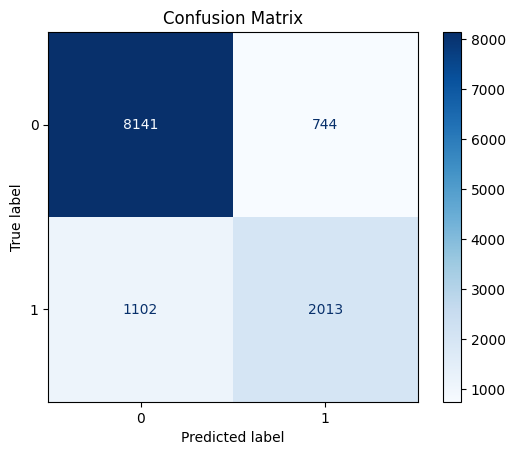

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

## New team standardized evaluation of the model

In [15]:
scores = calculate_scores(y_true, y_pred)
print(scores)

precision:	0.7301
recall:		0.6462
fscore:		0.6856
accuracy:	0.8462
tn: 8141	 fp: 744
fn: 1102	 tp: 2013


## New way of displaying the Confusion Matrix

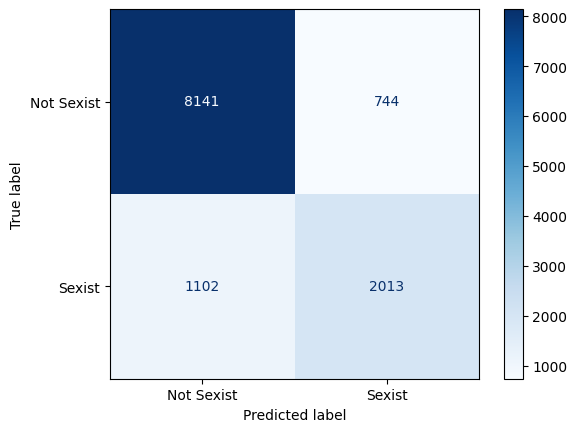

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=scores.confusion_matrix(), display_labels=["Not Sexist", "Sexist"]).plot(cmap="Blues")

In [17]:
mlflow.end_run()

## Report model to MlFlow

In [19]:
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="DeBERTa-v3-base gpu"
        ):
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("max_length", 128)
    mlflow.log_param("learning_rate", 5e-5)

    mlflow.log_metrics(scores.asdict())
    mlflow.set_tag("model", "DeBERTa-v3")

    mlflow.log_table({"id": test["id"], "prediction": y_pred}, "predictions_DeBERTa.json")
    mlflow.log_figure(disp.figure_, "confusion_matrix.png")

    # #log the model
    # prediction_data = {
    #     "columns": ["id", "prediction"],
    #     "data": [[id_, pred.tolist()] for id_, pred in zip(test["id"], y_pred)]
    # }
    # #save to a JSON file
    # predictions_file = RESOURCE / "mlflow/DeBERTa/predictions.json"
    # with open(predictions_file, "w") as f:
    #     json.dump(prediction_data, f, indent=4)
    #     
    # #log the JSON file 
    # mlflow.log_artifact(str(predictions_file))
        
    #simulate model registration
    mlflow.set_tag("registered_model_name", "DeBERTa-v3")
    mlflow.set_tag("model_alias", "current")

    #register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/predictions_DeBERTa.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="DeBERTa-v3") 
    # model_info: ModelInfo = mlflow.transformers.log_model(trainer, "", registered_model_name="deberta-v3-base")


client().set_registered_model_alias("DeBERTa-v3", "current", registered_model.version)

Registered model 'DeBERTa-v3' already exists. Creating a new version of this model...


2025/01/07 18:34:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DeBERTa-v3, version 2


Created version '2' of model 'DeBERTa-v3'.


🏃 View run DeBERTa-v3-base gpu at: https://mlflow.mahluke.page/#/experiments/769295261228132607/runs/1a7ac0a0b1064e9ba91de734c719ab77
🧪 View experiment at: https://mlflow.mahluke.page/#/experiments/769295261228132607


## Loading Predictions

In [ ]:
get_current("DeBERTa-v3")

In [ ]:
load_predictions("DeBERTa").head()

## *For me I got the logits of the model which need to be converted with sigmoid to get the probabilities of each class

In [ ]:
#Kind of uneccessary but I thought I needed it for the final output.
#Didn't know how it worked so I investigated and found out that predicted_test.predictions are logits which need to be converted to get the probs of each class
placeholder = torch.tensor(predicted_test.predictions)
classes_predicted = torch.sigmoid(placeholder)
classes_predicted